In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import logging
from model.models import Simulator
import service.regressor as regressor
import pickle
import seaborn as sns


import service.files_service as fs
import csv
import datetime

In [2]:
dataset = pickle.load(open('data/predictions/dataset_Open_Ask_USDCAD_with_10_shifts.p','rb'))

In [3]:
model = pickle.load(open('data/predictions/model_Open_Ask_USDCAD_with_10_shifts.p','rb'))

In [4]:
simulator = pickle.load(open('data/predictions/simulator_Open_Ask_USDCAD_with_10_shifts.p','rb'))

In [5]:
print model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


AttributeError: Unknown property size

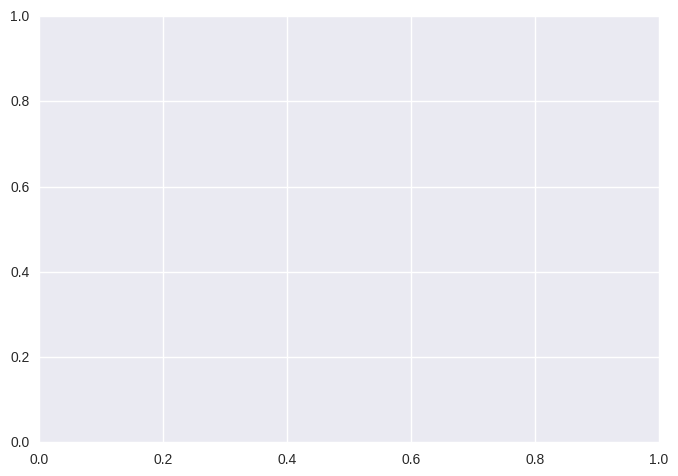

In [9]:
predict_proba = model.predict_proba(dataset['forecast_X'])
predict_discrete = model.predict(dataset['forecast_X'])
df_proba = pd.DataFrame(predict_proba)

df_discrete = df_proba.idxmax(axis=1)
df_proba['observed']= dataset['observed_y']
df_proba['predict_discrete']=predict_discrete
df_proba['score']=(df_proba.observed==df_proba.predict_discrete)
df_proba.score[:2000].plot(style='ro')

In [7]:
from sklearn.metrics import accuracy_score,confusion_matrix
print accuracy_score(dataset['observed_y'],df_discrete)
print model.score(dataset['forecast_X'],dataset['observed_y'])
print confusion_matrix(dataset['observed_y'], df_discrete)

0.970118721461
0.970118721461
[[53105    36]
 [ 1600     9]]
